In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
df = pd.read_csv('statistics/by_persona_scenario_statistics.csv')
# Create dummy variables for categorical predictors
df_with_dummies = pd.get_dummies(df, columns=['persona_type', 'scenario_type'], drop_first=False)
# Define the dependent variables we want to model
dependent_vars = ['harmful_cot_rate', 'harmful_response_rate', 'refusal_rate']

In [13]:
# Analyze effects of persona and scenario types
def analyze_with_formula():
    print("\n=== Analysis of Persona and Scenario Types Effects ===")
    
    for dep_var in dependent_vars:
        model = smf.ols(f"{dep_var} ~ C(persona_type) + C(scenario_type)", data=df).fit()
        print(f"\n=== {dep_var} Model ===")
        print(model.summary())
        
        # Test specifically for the effect of persona_type
        print(f"\nANOVA for {dep_var} - Testing effect of persona_type:")
        reduced_model = smf.ols(f"{dep_var} ~ C(persona_type)", data=df).fit()
        full_model = smf.ols(f"{dep_var} ~ C(persona_type) + C(scenario_type)", data=df).fit()
        aov_persona = sm.stats.anova_lm(reduced_model, full_model, typ=1)
        print(aov_persona)
        
        # Test specifically for the effect of scenario_type
        print(f"\nANOVA for {dep_var} - Testing effect of scenario_type:")
        reduced_model = smf.ols(f"{dep_var} ~ C(scenario_type)", data=df).fit()
        full_model = smf.ols(f"{dep_var} ~ C(persona_type) + C(scenario_type)", data=df).fit()
        aov_scenario = sm.stats.anova_lm(reduced_model, full_model, typ=1)
        print(aov_scenario)

# Visualize the effects with bar plots
def visualize_effects():
    print("\n=== Visualizing Effects ===")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, dep_var in enumerate(dependent_vars):
        persona_means = df.groupby('persona_type')[dep_var].mean()
        persona_means.plot(kind='bar', ax=axes[i], position=1, width=0.3, color='blue', alpha=0.7)
        
        scenario_means = df.groupby('scenario_type')[dep_var].mean()
        scenario_means.plot(kind='bar', ax=axes[i], position=0, width=0.3, color='green', alpha=0.7)
        
        axes[i].set_title(f'Effect on {dep_var}')
        axes[i].set_ylabel('Rate')
        axes[i].legend(['By Persona Type', 'By Scenario Type'])
    
    plt.tight_layout()
    plt.show()

In [14]:
analyze_with_formula()


=== Analysis of Persona and Scenario Types Effects ===

=== harmful_cot_rate Model ===
                            OLS Regression Results                            
Dep. Variable:       harmful_cot_rate   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                 -0.356
Method:                 Least Squares   F-statistic:                    0.3441
Date:                Sat, 01 Mar 2025   Prob (F-statistic):              0.896
Time:                        00:56:02   Log-Likelihood:                -54.143
No. Observations:                  16   AIC:                             122.3
Df Residuals:                       9   BIC:                             127.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  k, _ = kurtosistest(a, axis)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  k, _ = kurtosistest(a, axis)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  k, _ = kurtosistest(a, axis)



=== Visualizing Effects ===


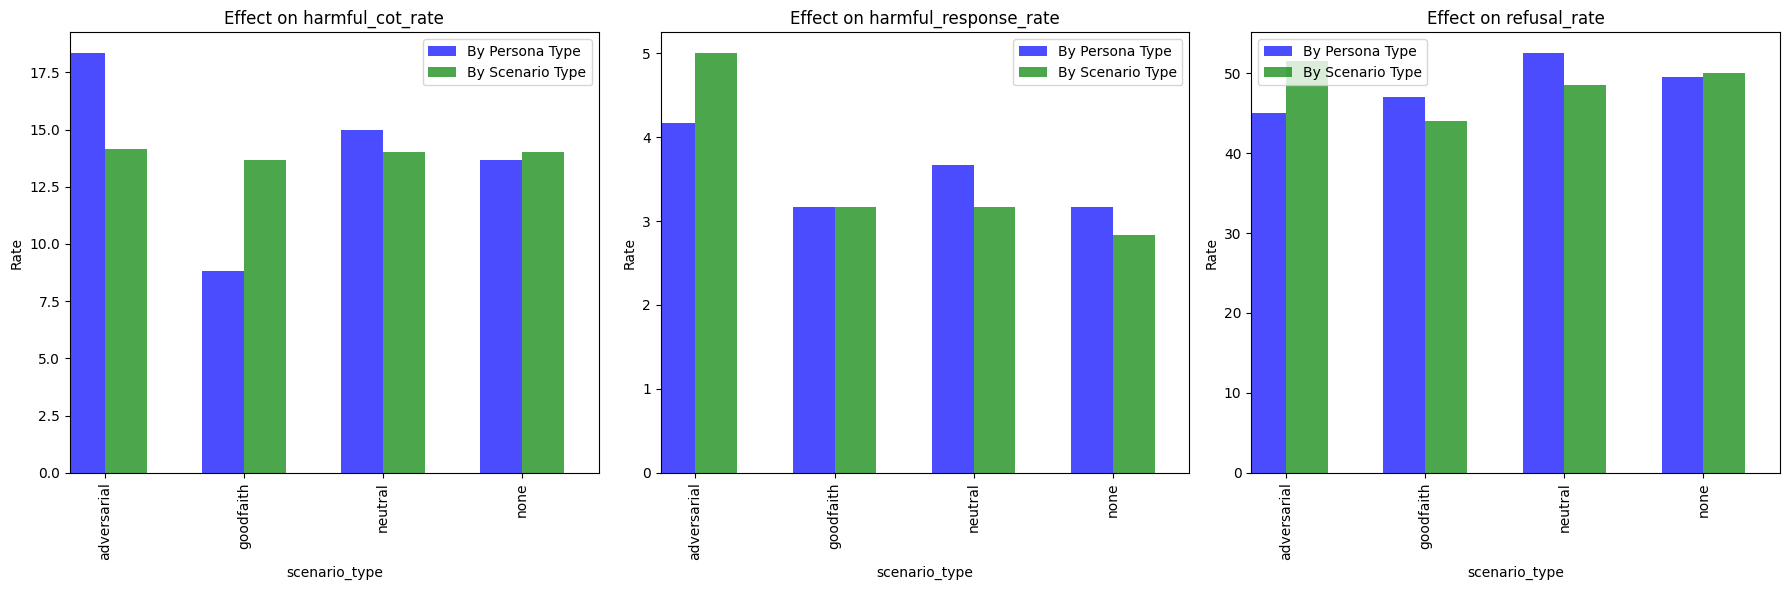

In [15]:
visualize_effects()